In [1]:
# Import Required Packages
%matplotlib inline
import numpy as np
#import networkx as nx
import time
import random
import json
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from sympy import *
from tqdm.notebook import tqdm

#From Qiskit library
from qiskit import *
from qiskit.visualization import *
from qiskit import IBMQ
from qiskit import BasicAer
from qiskit import Aer, execute
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.optimization.algorithms import MinimumEigenOptimizer, RecursiveMinimumEigenOptimizer
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.converters import QuadraticProgramToQubo
from qiskit.quantum_info import Statevector
from qiskit.providers.aer import StatevectorSimulator
from qiskit.circuit import Parameter
from qiskit.optimization.converters import IsingToQuadraticProgram
from qiskit.aqua.components.optimizers import NELDER_MEAD, CRS

In [2]:
qiskit.qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.1',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.1'}

In [3]:
#Function: Load JSON file
def loadjson( filename ):
    loaded_file = open(filename, "r")
    json_data = json.load(loaded_file)
    loaded_file.close()
    return json_data

#Function: Load Pickle file
def loadpkl( filename ):
    loaded_file = open(filename, "rb")
    pkl_data = pickle.load( loaded_file )
    loaded_file.close()
    return pkl_data

#Function: Get single term coefficients (to 4 decimal places) from Sympy Expression 
def get_coeff( variable, expression ):
    poly = Poly(expression.coeff(variable), domain = 'RR')
    return round(float(poly.coeffs()[len(poly.coeffs())-1]), 4)

#Function: Get coefficient of quadratic term (to 4 decimal places) from Sympy Expression
def quad_coeff( var_1, var_2, expression ):
    return round(float(expression.coeff(var_1).coeff(var_2)), 4)

In [7]:
pwd

'/home/jedwin/trafficQAOA'

In [6]:
import sys
sys.executable

'/home/jedwin/anaconda3/envs/QC/bin/python'

In [8]:
#Read and store files into variables
car_routes = loadjson( "3cars3routes.json" )
# H = loadjson( "Hamiltonian9qbits.json")
# [objective, Ham, objective_normed, Ham_normed] = loadpkl("expressions.pkl")
[total_cost, constraints] = loadpkl("cost_constraints.pkl")

In [9]:
car_routes

{'car1_route1': [[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5]],
 'car1_route2': [[0, 0],
  [0, 1],
  [1, 2],
  [2, 3],
  [3, 3],
  [3, 4],
  [4, 5],
  [5, 5]],
 'car1_route3': [[0, 0],
  [1, 0],
  [2, 1],
  [3, 1],
  [4, 2],
  [4, 3],
  [5, 4],
  [5, 5]],
 'car2_route1': [[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5]],
 'car2_route2': [[0, 0],
  [1, 0],
  [2, 1],
  [3, 2],
  [4, 3],
  [4, 4],
  [4, 5],
  [5, 5]],
 'car2_route3': [[0, 0],
  [1, 1],
  [2, 1],
  [2, 2],
  [3, 2],
  [3, 3],
  [4, 4],
  [5, 5]],
 'car3_route1': [[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5]],
 'car3_route2': [[0, 0], [0, 1], [1, 2], [2, 2], [3, 3], [4, 4], [5, 5]],
 'car3_route3': [[0, 0],
  [1, 1],
  [1, 2],
  [1, 3],
  [2, 3],
  [3, 3],
  [4, 4],
  [5, 5]]}

In [10]:
Q = IndexedBase('Q')
car_routes_variables = {}
for route in car_routes:
    car_routes_variables[route] = Q[route[3],route[10]]
car_routes_variables

{'car1_route1': Q[1, 1],
 'car1_route2': Q[1, 2],
 'car1_route3': Q[1, 3],
 'car2_route1': Q[2, 1],
 'car2_route2': Q[2, 2],
 'car2_route3': Q[2, 3],
 'car3_route1': Q[3, 1],
 'car3_route2': Q[3, 2],
 'car3_route3': Q[3, 3]}

In [11]:
no_routes = 3
no_cars = 3
no_qubits = no_routes * no_cars

In [12]:
#Associate binary variable to each Q11, Q12, etc with one index for QuadraticProgram class
binary_vars = {}
for variable in car_routes_variables:
    binary_vars[car_routes_variables[variable]] = 'X' + str(no_routes*(int(variable[3])-1)+int(variable[10]))
Qvariables = tuple(binary_vars.keys())
Xvariables = tuple(binary_vars.values())
print(binary_vars)

{Q[1, 1]: 'X1', Q[1, 2]: 'X2', Q[1, 3]: 'X3', Q[2, 1]: 'X4', Q[2, 2]: 'X5', Q[2, 3]: 'X6', Q[3, 1]: 'X7', Q[3, 2]: 'X8', Q[3, 3]: 'X9'}


In [13]:
#Construct Quadratic Problem using known (quadratic) objective function
penalty = 132*1.2
qubo1 = QuadraticProgram()
linear = []
for variable in car_routes_variables.values():
    qubo1.binary_var( binary_vars[variable] )
    linear.append( get_coeff(variable, total_cost) )
quadratic = {}
for i in range(no_qubits):
    for j in range(i+1, no_qubits):
        pairing = ( Xvariables[i], Xvariables[j] )
        coeff = quad_coeff( Qvariables[i], Qvariables[j], total_cost )
        quadratic[pairing] = coeff
qubo1.minimize(linear = linear, quadratic = quadratic)

#Add constraints
for car in constraints:
    i = 3*(int(car[3])-1) #to specify index of variable on next line
    qubo1.linear_constraint(linear={'X'+str(i+1): 1, 'X'+str(i+2): 1, 'X'+str(i+3): 1}, sense='==', rhs=1, name=str(car))

#Convert constrained Quadratic Problem into QUBO
converter = QuadraticProgramToQubo(penalty = penalty)
qubo1 = converter.convert(qubo1)
print(qubo1.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 256.800000000000 X1 - 240.800000000000 X2 - 198.800000000000 X3
      - 256.800000000000 X4 - 212.800000000000 X5 - 196.800000000000 X6
      - 256.800000000000 X7 - 230.800000000000 X8 - 214.800000000000 X9 + [
      316.800000000000 X1^2 + 633.600000000000 X1*X2 + 633.600000000000 X1*X3
      + 120 X1*X4 + 80 X1*X6 + 120 X1*X7 + 84 X1*X8 + 80 X1*X9
      + 316.800000000000 X2^2 + 633.600000000000 X2*X3 + 8 X2*X5 + 48 X2*X8
      + 8 X2*X9 + 316.800000000000 X3^2 + 48 X3*X5 + 316.800000000000 X4^2
      + 633.600000000000 X4*X5 + 713.600000000000 X4*X6 + 120 X4*X7 + 84 X4*X8
      + 80 X4*X9 + 316.800000000000 X5^2 + 633.600000000000 X5*X6
      + 316.800000000000 X6^2 + 80 X6*X7 + 68 X6*X8 + 80 X6*X9
      + 316.800000000000 X7^2 + 717.600000000000 X7*X8 + 713.600000000000 X7*X9
      + 316.800000000000 X8^2 + 701.600000000000 X8*X9 + 316.800000000000 X9^2
      ]/2 + 475.2000000000

In [14]:
op, offset = qubo1.to_ising()
print(op, offset)

SummedOp([
  -169.7 * IIIIIIIIZ,
  -125.2 * IIIIIIIZI,
  -144.2 * IIIIIIZII,
  -169.7 * IIIIIZIII,
  -138.2 * IIIIZIIII,
  -187.7 * IIIZIIIII,
  -169.7 * IIZIIIIII,
  -176.7 * IZIIIIIII,
  -179.7 * ZIIIIIIII,
  79.2 * IIIIIIIZZ,
  79.2 * IIIIIIZIZ,
  79.2 * IIIIIIZZI,
  15.0 * IIIIIZIIZ,
  IIIIZIIZI,
  6.0 * IIIIZIZII,
  79.2 * IIIIZZIII,
  10.0 * IIIZIIIIZ,
  89.2 * IIIZIZIII,
  79.2 * IIIZZIIII,
  15.0 * IIZIIIIIZ,
  15.0 * IIZIIZIII,
  10.0 * IIZZIIIII,
  10.5 * IZIIIIIIZ,
  6.0 * IZIIIIIZI,
  10.5 * IZIIIZIII,
  8.5 * IZIZIIIII,
  89.7 * IZZIIIIII,
  10.0 * ZIIIIIIIZ,
  ZIIIIIIZI,
  10.0 * ZIIIIZIII,
  10.0 * ZIIZIIIII,
  89.2 * ZIZIIIIII,
  87.7 * ZZIIIIIII
]) 1045.7000000000003


In [15]:
coeffs = [abs(op.oplist[i].coeff) for i in range(len(op.oplist))]
norm_factor = np.amax(coeffs)
norm_factor

187.7

In [256]:
#Normalised objective function
qubo = QuadraticProgram()
linear = []
for variable in car_routes_variables.values():
    qubo.binary_var( binary_vars[variable] )
    linear.append( (get_coeff(variable, total_cost)/norm_factor) )
quadratic = {}
for i in range(no_qubits):
    for j in range(i+1, no_qubits):
        pairing = ( Xvariables[i], Xvariables[j] )
        coeff = quad_coeff( Qvariables[i], Qvariables[j], total_cost )
        quadratic[pairing] = (coeff/norm_factor)
qubo.minimize(linear = linear, quadratic = quadratic)

#Add constraints
for car in constraints:
    i = 3*(int(car[3])-1) #to specify index of variable on next line
    qubo.linear_constraint(linear={'X'+str(i+1): 1, 'X'+str(i+2): 1, 'X'+str(i+3): 1}, sense='==', rhs=1, name=str(car))

#Convert constrained Quadratic Problem into QUBO
converter = QuadraticProgramToQubo(penalty = penalty/norm_factor)
qubo = converter.convert(qubo)
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex

\ ENCODING=ISO-8859-1

\Problem name: CPLEX



Minimize

 obj: - 1.368140649973 X1 - 1.282898241875 X2 - 1.059136920618 X3

      - 1.368140649973 X4 - 1.133724027704 X5 - 1.048481619606 X6

      - 1.368140649973 X7 - 1.229621736814 X8 - 1.144379328716 X9 + [

      1.687799680341 X1^2 + 3.375599360682 X1*X2 + 3.375599360682 X1*X3

      + 0.639318060735 X1*X4 + 0.426212040490 X1*X6 + 0.639318060735 X1*X7

      + 0.447522642515 X1*X8 + 0.426212040490 X1*X9 + 1.687799680341 X2^2

      + 3.375599360682 X2*X3 + 0.042621204049 X2*X5 + 0.255727224294 X2*X8

      + 0.042621204049 X2*X9 + 1.687799680341 X3^2 + 0.255727224294 X3*X5

      + 1.687799680341 X4^2 + 3.375599360682 X4*X5 + 3.801811401172 X4*X6

      + 0.639318060735 X4*X7 + 0.447522642515 X4*X8 + 0.426212040490 X4*X9

      + 1.687799680341 X5^2 + 3.375599360682 X5*X6 + 1.687799680341 X6^2

      + 0.426212040490 X6*X7 + 0.362280234417 X6*X8 + 0.426212040490 X6*X9

      + 1.687799680

In [257]:
op, offset = qubo.to_ising()
print(op, offset)

SummedOp([

  -0.9041022908897177 * IIIIIIIIZ,

  -0.6670218433670753 * IIIIIIIZI,

  -0.7682472029834843 * IIIIIIZII,

  -0.9041022908897177 * IIIIIZIII,

  -0.7362812999467236 * IIIIZIIII,

  -1.0 * IIIZIIIII,

  -0.9041022908897176 * IIZIIIIII,

  -0.9413958444326054 * IZIIIIIII,

  -0.9573787959509856 * ZIIIIIIII,

  0.42194992008524246 * IIIIIIIZZ,

  0.42194992008524246 * IIIIIIZIZ,

  0.42194992008524246 * IIIIIIZZI,

  0.07991475759190197 * IIIIIZIIZ,

  0.005327650506126798 * IIIIZIIZI,

  0.03196590303676079 * IIIIZIZII,

  0.42194992008524246 * IIIIZZIII,

  0.053276505061267986 * IIIZIIIIZ,

  0.4752264251465104 * IIIZIZIII,

  0.42194992008524246 * IIIZZIIII,

  0.07991475759190197 * IIZIIIIIZ,

  0.07991475759190197 * IIZIIZIII,

  0.053276505061267986 * IIZZIIIII,

  0.055940330314331384 * IZIIIIIIZ,

  0.03196590303676079 * IZIIIIIZI,

  0.055940330314331384 * IZIIIZIII,

  0.045285029302077784 * IZIZIIIII,

  0.47789025039957383 * IZZIIIIII,

  0.053276505061267986 * Z

In [258]:
qaoa_mes = QAOA(quantum_instance=Aer.get_backend('statevector_simulator'))
exact_mes = NumPyMinimumEigensolver()
qaoa = MinimumEigenOptimizer(qaoa_mes)   # using QAOA
exact = MinimumEigenOptimizer(exact_mes)  # using the exact classical numpy minimum eigen solver

In [259]:
%%time
exact_result = exact.solve(qubo)
print(exact_result)

optimal function value: 1.2999467234949391

optimal value: [0. 1. 0. 0. 1. 0. 1. 0. 0.]

status: SUCCESS

CPU times: user 85.1 ms, sys: 4.06 ms, total: 89.1 ms

Wall time: 86.6 ms


In [260]:
#Binary string x of length 9, using cost/obj function from QUBO on QuadraticProgram qp.
def eval_cost(x, qubo_problem):
    return qubo_problem.objective.evaluate([int(x[no_qubits-1-i]) for i in range(no_qubits)])

In [261]:
values = {}
for k in range(2**9):
    string = '{0:09b}'.format(k)
    values[string] = eval_cost(string, qubo)
sort_values = sorted(values.items(), key=lambda x: x[1])
for string, cost in sort_values:
    print(string, round(cost,3), string[0:3].count('1')==1 and string[3:6].count('1')==1 and string[6:9].count('1')==1)

001010010 1.3 True

001001010 1.364 True

100001010 1.502 True

001010001 1.513 True

010001010 1.534 True

100010010 1.545 True

010010001 1.556 True

010010010 1.566 True

000001010 1.568 False

001000010 1.568 False

001100010 1.577 True

001001100 1.588 True

010001100 1.63 True

100010001 1.63 True

001010100 1.63 True

100001100 1.705 True

000010001 1.718 False

001010000 1.718 False

010010100 1.769 True

000001100 1.792 False

001000100 1.792 False

001100100 1.801 True

000001001 1.803 False

001000001 1.803 False

001001000 1.803 False

010100010 1.811 True

100000010 1.814 False

100100010 1.822 True

000010010 1.824 False

010000010 1.835 False

010000001 1.845 False

010001000 1.845 False

100010100 1.854 True

010010000 1.856 False

010001001 1.865 True

000100010 1.888 False

010100100 1.907 True

001001001 1.918 True

100000001 1.92 False

100001000 1.92 False

100001001 1.929 True

010000100 1.931 False

100010000 1.941 False

000000001 2.007 False

000001000 2.007 Fa

In [286]:
#Variables
simulator = StatevectorSimulator()
step_size = 0.2
gammas = np.arange(-2,2,step_size)
betas = np.arange(-2,2,step_size)
optimizer = NELDER_MEAD(maxfev = 10000)

#Function: Algorithm to find optimal parameters for qaoa circuit of layer k associated to the qubo_problem
def find_optimal_params( k, qubo_problem ):
    fixed_params = []
    for p in range( k ):
        p += 1 #Reindex beginning from step p=1
       
        print(f'Step {p}: Building circuit...')
        qaoa_circuit = qaoa_circ( p, qubo_problem )
        print(f'Step {p}: Building circuit...Done')
        
        #Measure Expectation Values for a rough heatmap
        print(f'\nStep {p}: Calculating expectation values and then plotting heatmap...')
        results_2d = plot_heatmap( qaoa_circuit, qubo_problem, fixed_params )
        if p==1:
            fixed_params = np.append(fixed_params, results_2d)
        else:
            fixed_params = np.insert(fixed_params, p-1, results_2d[0])
            fixed_params = np.append(fixed_params, results_2d[1])
            
        print(f'Step {p}: Now optimising parameters (Nelder-Mead)...')
        print('initial point: pi*'+str(fixed_params))
        variable_bounds = [ (-np.pi, np.pi) for _ in range(2*p)]
        obj_expectation = lambda x: expectation( qaoa_circuit, qubo_problem, x ) #Define obj_function that inputs only parameters
        optimal_result = optimizer.optimize(num_vars = 2*p,
                                            objective_function = obj_expectation,
                                            variable_bounds= variable_bounds, 
                                            initial_point=fixed_params*np.pi)
        optimal_params = optimal_result[0]/np.pi
        print(optimal_result)
        print("params/np.pi: ", optimal_params)
        fixed_params = optimal_params
        print(f'Step {p} Done')
        print('----------------------------------')
    return fixed_params
    
#Function: Build qaoa circuit of layers p, starting from qubo_problem = QuadraticProgram describing the problem
#  returns [no. of layers, qubo_problem, <circuit>]
def qaoa_circ( p, qubo_problem ):
    params_expr = []
    op = qubo_problem.to_ising()[0]
    for a in range(p):
        params_expr.append( Parameter('a'+str(a+1)) )
    for a in range(p):
        params_expr.append( Parameter('b'+str(a+1)) )
    qaoa = QAOA(operator = op, p=p, quantum_instance=Aer.get_backend('statevector_simulator'))
    circuit = qaoa.construct_circuit( params_expr[0:2*p] )[0]
    return p, params_expr, circuit

#Function: Plot 2D heat-map of expectation values of parameters of outermost layer at a given step k
def plot_heatmap( qaoa_circuit, qubo_problem, fixed_params ):
    p = qaoa_circuit[0]
    
    #Initialise exp_value 2d array with 0s.
    exp_vals = np.zeros((len(gammas), len(betas)))
    
    if p == 1:
        for a in tqdm(range(len(gammas))):
            for b in range(len(betas)):        
                gammas_betas = np.array([gammas[a],betas[b]])
                exp_vals[a][b] = expectation( qaoa_circuit, qubo_problem, gammas_betas*np.pi )

    else:
        for a in tqdm(range(len(gammas))):
            for b in range(len(betas)):
                gammas_betas = np.insert(fixed_params, p-1, gammas[a])
                gammas_betas = np.append(gammas_betas, betas[b])
                exp_vals[a][b] = expectation( qaoa_circuit, qubo_problem, gammas_betas*np.pi )
        
    exp_min = np.amin(exp_vals)
    min_index = np.where(exp_vals == exp_min)
    print(f'min: {exp_min}, gamma = {round(gammas[min_index[0][0]], 2)}*pi, beta = {round(betas[min_index[1][0]], 2)}*pi')
    print("Now drawing plot...")
    x, y = np.meshgrid(gammas, betas)
    z = exp_vals
    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(x, y, z)
    fig.colorbar(cp)
    ax.set_xlabel('beta/pi (cm)')
    ax.set_ylabel('gamma/pi (cm)')
    plt.show()
    return gammas[min_index[0][0]], betas[min_index[1][0]]

#Find expectation value of prepared state from qaoa_circuit = [no_layers, <circuit>], must have len(params) == 2*no_layers
def expectation( qaoa_circuit, qubo_problem, params ):
    p = qaoa_circuit[0]
    params_expr = qaoa_circuit[1]
    circuit = qaoa_circuit[2]
    if len(params) != 2*p:
        print("Must have len(params) == 2*no_layers")
    else:
        exp_val = 0
        circuit2 = circuit.assign_parameters({params_expr[i]: params[i] for i in range(len(params))}, inplace = False)
        result = execute(circuit2, simulator).result()
        statevector = Statevector(result.get_statevector())
        prob_dict = statevector.probabilities_dict(decimals = 8)
        for state in prob_dict:
            exp_val += prob_dict[state] * eval_cost(state, qubo_problem)
        return np.round(exp_val, 6)

#Binary string x of length 9, using cost/obj function from QUBO on QuadraticProgram qp.
def eval_cost(x, qubo_problem):
    return qubo_problem.objective.evaluate([int(x[no_qubits-1-i]) for i in range(no_qubits)])

Step 1: Building circuit...

Step 1: Building circuit...Done



Step 1: Calculating expectation values and then plotting heatmap...




min: 2.739514, gamma = -0.2*pi, beta = -1.6*pi

Now drawing plot...


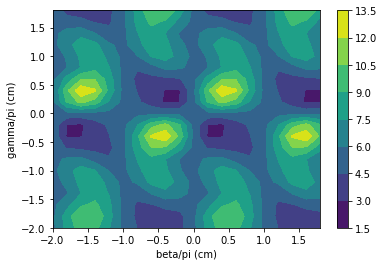

Step 1: Now optimising parameters (Nelder-Mead)...

initial point: pi*[-0.2 -1.6]

(array([-0.91120637, -5.35236737]), 2.313864, 67)

params/np.pi:  [-0.290046   -1.70371145]

Step 1 Done

----------------------------------

Step 2: Building circuit...

Step 2: Building circuit...Done



Step 2: Calculating expectation values and then plotting heatmap...




min: 2.313864, gamma = -2.0*pi, beta = -2.0*pi

Now drawing plot...


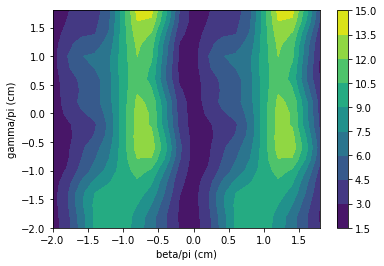

Step 2: Now optimising parameters (Nelder-Mead)...

initial point: pi*[-0.290046   -2.         -1.70371145 -2.        ]

(array([-0.84899585, -4.86061475, -5.52351816, -6.58266315]), 2.119377, 166)

params/np.pi:  [-0.27024377 -1.54718173 -1.75819044 -2.09532676]

Step 2 Done

----------------------------------

Step 3: Building circuit...

Step 3: Building circuit...Done



Step 3: Calculating expectation values and then plotting heatmap...




min: 2.119377, gamma = -2.0*pi, beta = -2.0*pi

Now drawing plot...


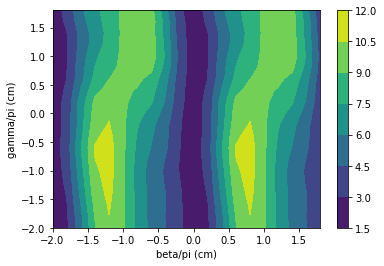

Step 3: Now optimising parameters (Nelder-Mead)...

initial point: pi*[-0.27024377 -1.54718173 -2.         -1.75819044 -2.09532676 -2.        ]

(array([-0.84256715, -4.73179711, -7.28097546, -5.54529921, -6.74611199,

       -5.9816079 ]), 1.96343, 262)

params/np.pi:  [-0.26819745 -1.5061778  -2.31760647 -1.76512356 -2.14735414 -1.90400493]

Step 3 Done

----------------------------------

Step 4: Building circuit...

Step 4: Building circuit...Done



Step 4: Calculating expectation values and then plotting heatmap...




min: 1.96343, gamma = -2.0*pi, beta = -2.0*pi

Now drawing plot...


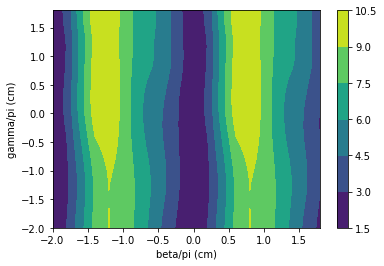

Step 4: Now optimising parameters (Nelder-Mead)...

initial point: pi*[-0.26819745 -1.5061778  -2.31760647 -2.         -1.76512356 -2.14735414

 -1.90400493 -2.        ]

(array([-0.83719217, -4.62495726, -7.07514035, -6.95643422, -5.54166191,

       -6.79532908, -5.85246856, -6.4699748 ]), 1.930833, 283)

params/np.pi:  [-0.26648654 -1.47216962 -2.25208712 -2.21430178 -1.76396577 -2.16302043

 -1.8628986  -2.05945694]

Step 4 Done

----------------------------------

Step 5: Building circuit...

Step 5: Building circuit...Done



Step 5: Calculating expectation values and then plotting heatmap...




min: 1.930833, gamma = -2.0*pi, beta = -2.0*pi

Now drawing plot...


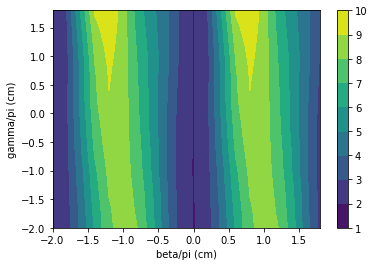

Step 5: Now optimising parameters (Nelder-Mead)...

initial point: pi*[-0.26648654 -1.47216962 -2.25208712 -2.21430178 -2.         -1.76396577

 -2.16302043 -1.8628986  -2.05945694 -2.        ]

(array([-0.83798221, -4.61229055, -7.01854884, -6.92563642, -7.33456049,

       -5.54212336, -6.800355  , -5.83015967, -6.51820522, -6.23529904]), 1.929467, 545)

params/np.pi:  [-0.26673802 -1.46813768 -2.23407348 -2.20449854 -2.33466312 -1.76411266

 -2.16462023 -1.85579746 -2.07480916 -1.98475733]

Step 5 Done

----------------------------------

CPU times: user 24min 34s, sys: 1.74 s, total: 24min 36s

Wall time: 24min 36s


In [270]:
%%time
optimal_parameters = find_optimal_params( 10, qubo )

In [268]:
k=5
qaoa_circ = QAOA(operator = op, p=k, quantum_instance=BasicAer.get_backend('statevector_simulator'))
optimal_circuit = qaoa_circ.construct_circuit( optimal_parameters[0:2*k] )[0]
simulator = Aer.get_backend('statevector_simulator')
result = execute(optimal_circuit, simulator).result()
statevector = Statevector(result.get_statevector())
counts = statevector.sample_counts(shots = 10000)
plot_histogram([counts], figsize = (200,100))

In [19]:
sort_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
sort_counts

[('100010001', 589),
 ('010010001', 553),
 ('100001001', 510),
 ('010001001', 493),
 ('100010100', 427),
 ('100001100', 386),
 ('001010010', 360),
 ('001010100', 353),
 ('001010001', 352),
 ('001001100', 343),
 ('100010010', 324),
 ('001001010', 323),
 ('010010010', 312),
 ('001100001', 310),
 ('010001100', 302),
 ('010010100', 291),
 ('010100001', 271),
 ('100100001', 271),
 ('001001001', 267),
 ('100001010', 266),
 ('001001000', 256),
 ('010001010', 242),
 ('001100100', 238),
 ('001100000', 213),
 ('100100100', 183),
 ('001010000', 144),
 ('010001000', 133),
 ('010100100', 133),
 ('100001000', 115),
 ('010010000', 67),
 ('001000001', 57),
 ('001100010', 55),
 ('100000001', 54),
 ('010100000', 49),
 ('100100000', 46),
 ('000010010', 41),
 ('001000100', 39),
 ('000010001', 36),
 ('100010000', 36),
 ('000001010', 35),
 ('001000010', 35),
 ('000001001', 34),
 ('100100010', 33),
 ('010000001', 31),
 ('010100010', 31),
 ('000100001', 30),
 ('001000000', 30),
 ('000100100', 24),
 ('00000110

In [271]:
def continue_find_optimal_params( found_params, k_done, k, qubo_problem ):
    fixed_params = found_params
    for p in range( k_done, k ):
        p += 1 #Reindex (so numbering of steps begin from 1 and not 0)
       
        print(f'Step {p}: Building circuit...')
        qaoa_circuit = qaoa_circ( p, qubo_problem )
        print(f'Step {p}: Building circuit...Done')
        
        #Measure Expectation Values for a rough heatmap
        print(f'\nStep {p}: Calculating expectation values and then plotting heatmap...')
        results_2d = plot_heatmap( qaoa_circuit, qubo_problem, fixed_params )
        if p==1:
            fixed_params = np.append(fixed_params, results_2d)
        else:
            fixed_params = np.insert(fixed_params, p-1, results_2d[0])
            fixed_params = np.append(fixed_params, results_2d[1])
            
        print(f'Step {p}: Now optimising parameters (Nelder-Mead)...')
        print('initial point: pi*'+str(fixed_params))
        variable_bounds = [ (-np.pi, np.pi) for _ in range(2*p)]
        obj_expectation = lambda x: expectation( qaoa_circuit, qubo_problem, x ) #Define obj_function that inputs only parameters
        optimal_result = optimizer.optimize(num_vars = 2*p,
                                            objective_function = obj_expectation,
                                            variable_bounds= variable_bounds, 
                                            initial_point=fixed_params*np.pi)
        optimal_params = optimal_result[0]/np.pi
        print(optimal_result)
        print("params/np.pi: ", optimal_params)
        fixed_params = optimal_params
        print(f'Step {p} Done')
        print('----------------------------------')
    return fixed_params

Step 6: Building circuit...

Step 6: Building circuit...Done



Step 6: Calculating expectation values and then plotting heatmap...




min: 1.929467, gamma = -2.0*pi, beta = -2.0*pi

Now drawing plot...


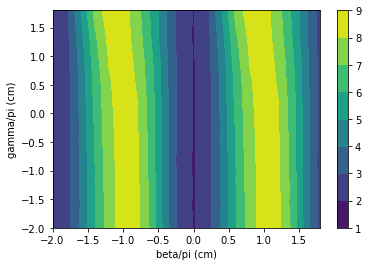

Step 6: Now optimising parameters (Nelder-Mead)...

initial point: pi*[-0.26673802 -1.46813768 -2.23407348 -2.20449854 -2.33466312 -2.

 -1.76411266 -2.16462023 -1.85579746 -2.07480916 -1.98475733 -2.        ]

(array([-0.77511937, -3.67967119, -5.69889511, -7.25673718, -3.93951749,

       -7.55647627, -5.3283041 , -6.34900074, -5.76038722, -6.44478526,

       -5.91513196, -6.51196417]), 1.889785, 2602)

params/np.pi:  [-0.24672816 -1.17127572 -1.81401465 -2.30989119 -1.25398736 -2.4053011

 -1.69605187 -2.0209497  -1.8335882  -2.05143886 -1.88284498 -2.07282257]

Step 6 Done

----------------------------------

Step 7: Building circuit...

Step 7: Building circuit...Done



Step 7: Calculating expectation values and then plotting heatmap...




min: 1.889785, gamma = -2.0*pi, beta = -2.0*pi

Now drawing plot...


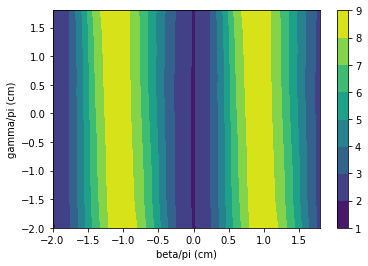

Step 7: Now optimising parameters (Nelder-Mead)...

initial point: pi*[-0.24672816 -1.17127572 -1.81401465 -2.30989119 -1.25398736 -2.4053011

 -2.         -1.69605187 -2.0209497  -1.8335882  -2.05143886 -1.88284498

 -2.07282257 -2.        ]

(array([-0.76993529, -3.87749092, -5.46323198, -7.26190862, -3.94868932,

       -7.58428021, -7.84146808, -5.33421175, -6.34065317, -5.7556457 ,

       -6.46293557, -5.89095408, -6.61191606, -6.18113247]), 1.88159, 1119)

params/np.pi:  [-0.24507801 -1.23424369 -1.73900075 -2.31153731 -1.25690685 -2.41415137

 -2.49601681 -1.69793233 -2.01829259 -1.83207893 -2.05721629 -1.87514892

 -2.10463825 -1.96751557]

Step 7 Done

----------------------------------

Step 8: Building circuit...

Step 8: Building circuit...Done



Step 8: Calculating expectation values and then plotting heatmap...




min: 1.88159, gamma = -2.0*pi, beta = -2.0*pi

Now drawing plot...


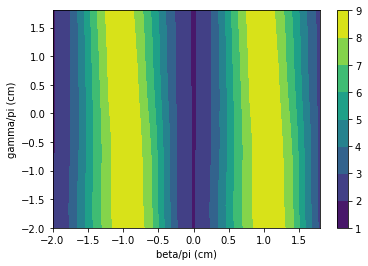

Step 8: Now optimising parameters (Nelder-Mead)...

initial point: pi*[-0.24507801 -1.23424369 -1.73900075 -2.31153731 -1.25690685 -2.41415137

 -2.49601681 -2.         -1.69793233 -2.01829259 -1.83207893 -2.05721629

 -1.87514892 -2.10463825 -1.96751557 -2.        ]

(array([-0.77603022, -3.89749464, -5.4576094 , -7.19832117, -3.98854854,

       -7.18199344, -6.52949623, -7.03673159, -5.34907871, -6.3507406 ,

       -5.76808688, -6.4482183 , -5.86274045, -6.64755894, -6.05681057,

       -6.44990318]), 1.863247, 1137)

params/np.pi:  [-0.24701809 -1.24061107 -1.73721103 -2.29129679 -1.26959443 -2.28609951

 -2.0784032  -2.23986123 -1.70266464 -2.02150352 -1.83603908 -2.05253163

 -1.86616825 -2.11598373 -1.92794268 -2.05306795]

Step 8 Done

----------------------------------

Step 9: Building circuit...

Step 9: Building circuit...Done



Step 9: Calculating expectation values and then plotting heatmap...




min: 1.863247, gamma = -2.0*pi, beta = -2.0*pi

Now drawing plot...


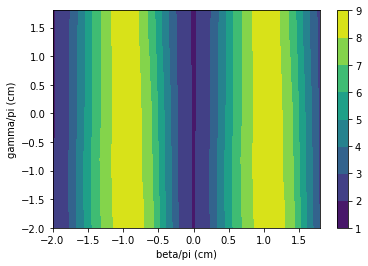

Step 9: Now optimising parameters (Nelder-Mead)...

initial point: pi*[-0.24701809 -1.24061107 -1.73721103 -2.29129679 -1.26959443 -2.28609951

 -2.0784032  -2.23986123 -2.         -1.70266464 -2.02150352 -1.83603908

 -2.05253163 -1.86616825 -2.11598373 -1.92794268 -2.05306795 -2.        ]

(array([-0.78072282, -3.89247724, -5.44096331, -7.18895271, -3.88996112,

       -7.071545  , -6.46765067, -6.87524892, -6.63368049, -5.35324277,

       -6.35587865, -5.77704948, -6.43903485, -5.85425629, -6.66267119,

       -6.02146019, -6.48916911, -6.2271249 ]), 1.861694, 958)

params/np.pi:  [-0.24851179 -1.23901399 -1.73191241 -2.28831472 -1.23821308 -2.25094269

 -2.05871715 -2.1884597  -2.11156608 -1.7039901  -2.02313901 -1.83889196

 -2.04960845 -1.86346765 -2.12079411 -1.91669031 -2.06556668 -1.98215542]

Step 9 Done

----------------------------------

Step 10: Building circuit...

Step 10: Building circuit...Done



Step 10: Calculating expectation values and then plotting heatmap...




min: 1.861694, gamma = -2.0*pi, beta = -2.0*pi

Now drawing plot...


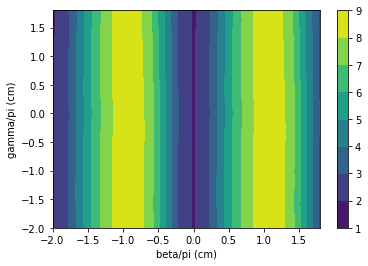

Step 10: Now optimising parameters (Nelder-Mead)...

initial point: pi*[-0.24851179 -1.23901399 -1.73191241 -2.28831472 -1.23821308 -2.25094269

 -2.05871715 -2.1884597  -2.11156608 -2.         -1.7039901  -2.02313901

 -1.83889196 -2.04960845 -1.86346765 -2.12079411 -1.91669031 -2.06556668

 -1.98215542 -2.        ]

(array([-0.80405099, -3.69367307, -5.3927429 , -7.10454927, -3.90689826,

       -7.05427191, -5.31657519, -6.80587883, -6.03125407, -6.20187867,

       -5.33624676, -6.30745172, -5.7712569 , -6.40828196, -5.78541749,

       -6.65251484, -6.02379173, -6.63013491, -6.15060559, -6.44285639]), 1.853662, 3171)

params/np.pi:  [-0.25593738 -1.17573265 -1.71656338 -2.26144827 -1.24360434 -2.24544449

 -1.69231844 -2.16637852 -1.9198078  -1.97411929 -1.6985801  -2.00772424

 -1.83704813 -2.0398195  -1.84155558 -2.11756124 -1.91743246 -2.11043749

 -1.95779857 -2.05082488]

Step 10 Done

----------------------------------


In [272]:
optimal_parameters = continue_find_optimal_params(optimal_parameters, 5, 10, qubo)

In [295]:
k=10
qaoa_circ = QAOA(operator = op, p=k, quantum_instance=BasicAer.get_backend('statevector_simulator'))
optimal_circuit = qaoa_circ.construct_circuit( np.pi*optimal_parameters[0:2*k] )[0]
simulator = Aer.get_backend('statevector_simulator')
result = execute(optimal_circuit, simulator).result()
statevector = Statevector(result.get_statevector())
counts = statevector.sample_counts(shots = 10000)
plot_histogram([counts], figsize = (200,100))

Step 11: Building circuit...

Step 11: Building circuit...Done



Step 11: Calculating expectation values and then plotting heatmap...




min: 1.853662, gamma = -2.0*pi, beta = -2.0*pi

Now drawing plot...


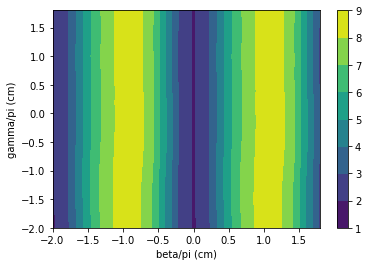

Step 11: Now optimising parameters (Nelder-Mead)...

initial point: pi*[-0.25593738 -1.17573265 -1.71656338 -2.26144827 -1.24360434 -2.24544449

 -1.69231844 -2.16637852 -1.9198078  -1.97411929 -2.         -1.6985801

 -2.00772424 -1.83704813 -2.0398195  -1.84155558 -2.11756124 -1.91743246

 -2.11043749 -1.95779857 -2.05082488 -2.        ]

(array([-0.8027288 , -3.71077448, -5.37040576, -7.16561768, -3.81801682,

       -7.08605152, -4.99335028, -6.85375218, -6.01745152, -6.58104452,

       -7.69096036, -5.32188171, -6.29577016, -5.76834085, -6.41111778,

       -5.78794737, -6.62672632, -6.00111879, -6.6926541 , -6.04525306,

       -6.56731552, -6.19488688]), 1.848814, 2036)

params/np.pi:  [-0.25551651 -1.1811762  -1.70945325 -2.28088695 -1.2153125  -2.25556025

 -1.58943276 -2.18161708 -1.91541431 -2.09481153 -2.44810872 -1.69400756

 -2.00400588 -1.83611992 -2.04072217 -1.84236087 -2.1093525  -1.91021544

 -2.13033797 -1.92426381 -2.09044145 -1.97189374]

Step 11 Done

----------



min: 1.848814, gamma = -2.0*pi, beta = -2.0*pi

Now drawing plot...


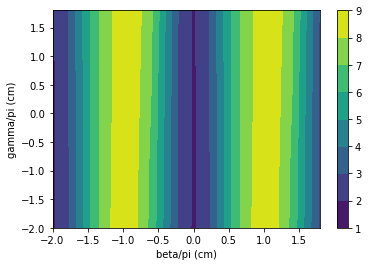

Step 12: Now optimising parameters (Nelder-Mead)...

initial point: pi*[-0.25551651 -1.1811762  -1.70945325 -2.28088695 -1.2153125  -2.25556025

 -1.58943276 -2.18161708 -1.91541431 -2.09481153 -2.44810872 -2.

 -1.69400756 -2.00400588 -1.83611992 -2.04072217 -1.84236087 -2.1093525

 -1.91021544 -2.13033797 -1.92426381 -2.09044145 -1.97189374 -2.        ]

(array([-0.79299542, -3.77458006, -5.30014773, -7.1984621 , -3.83112498,

       -7.17446697, -4.74241017, -6.97672263, -6.08646346, -6.61191253,

       -8.91612031, -4.60207159, -5.32209026, -6.29286886, -5.75749453,

       -6.42523182, -5.7963764 , -6.61776147, -6.03748687, -6.6546719 ,

       -6.09349889, -6.49422251, -6.19327716, -6.20198806]), 1.845821, 2537)

params/np.pi:  [-0.25241828 -1.20148615 -1.68708942 -2.29134165 -1.21948496 -2.28370377

 -1.50955604 -2.22075979 -1.93738149 -2.10463713 -2.83808924 -1.46488488

 -1.69407395 -2.00308237 -1.83266743 -2.04521481 -1.84504391 -2.1064989

 -1.92179176 -2.11824786 -1.939620



min: 1.845821, gamma = -2.0*pi, beta = -2.0*pi

Now drawing plot...


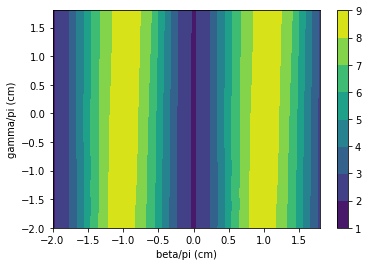

Step 13: Now optimising parameters (Nelder-Mead)...

initial point: pi*[-0.25241828 -1.20148615 -1.68708942 -2.29134165 -1.21948496 -2.28370377

 -1.50955604 -2.22075979 -1.93738149 -2.10463713 -2.83808924 -1.46488488

 -2.         -1.69407395 -2.00308237 -1.83266743 -2.04521481 -1.84504391

 -2.1064989  -1.92179176 -2.11824786 -1.93962094 -2.06717523 -1.97138135

 -1.97415411 -2.        ]

(array([-0.7889431 , -3.82266182, -5.2579647 , -7.21108773, -3.80190055,

       -7.20521162, -4.72641224, -7.0241886 , -6.12853321, -6.61997519,

       -8.93836125, -4.97141083, -6.26496533, -5.32107093, -6.29558965,

       -5.75439173, -6.43085383, -5.79722655, -6.63238408, -6.05273179,

       -6.6526228 , -6.10673655, -6.49369228, -6.18622377, -6.21203068,

       -6.24578953]), 1.845172, 1516)

params/np.pi:  [-0.25112839 -1.21679105 -1.67366214 -2.29536051 -1.21018253 -2.29349009

 -1.50446374 -2.23586867 -1.95077271 -2.10720355 -2.84516875 -1.58244921

 -1.9942004  -1.69374948 -2.00394843 -



min: 1.845172, gamma = -2.0*pi, beta = -2.0*pi

Now drawing plot...


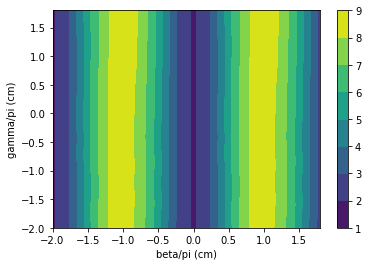

Step 14: Now optimising parameters (Nelder-Mead)...

initial point: pi*[-0.25112839 -1.21679105 -1.67366214 -2.29536051 -1.21018253 -2.29349009

 -1.50446374 -2.23586867 -1.95077271 -2.10720355 -2.84516875 -1.58244921

 -1.9942004  -2.         -1.69374948 -2.00394843 -1.83167978 -2.04700435

 -1.84531452 -2.11115342 -1.92664437 -2.11759561 -1.94383462 -2.06700645

 -1.96913619 -1.97735078 -1.98809655 -2.        ]

(array([-0.76268578, -3.76601909, -5.45607547, -7.21616139, -3.87040824,

       -7.22258062, -6.42856767, -6.78822401, -5.36612016, -6.18103038,

       -7.27342438, -6.17489042, -6.65457014, -7.22221147, -5.33431552,

       -6.334136  , -5.76432341, -6.46182899, -5.8936081 , -6.65627106,

       -6.04803291, -6.5006361 , -6.24450091, -6.51724708, -6.04175064,

       -6.5028325 , -5.92813914, -6.50808268]), 1.835053, 10000)

params/np.pi:  [-0.24277042 -1.19876111 -1.73672276 -2.29697551 -1.23198921 -2.29901882

 -2.04627664 -2.16075881 -1.7080891  -1.96748308 -2.31520289 



min: 1.835053, gamma = -2.0*pi, beta = -2.0*pi

Now drawing plot...


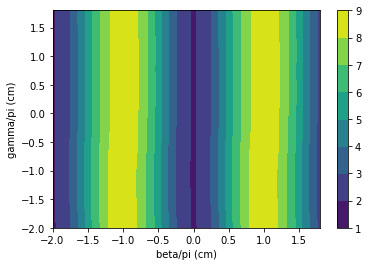

Step 15: Now optimising parameters (Nelder-Mead)...

initial point: pi*[-0.24277042 -1.19876111 -1.73672276 -2.29697551 -1.23198921 -2.29901882

 -2.04627664 -2.16075881 -1.7080891  -1.96748308 -2.31520289 -1.96552867

 -2.11821546 -2.29890131 -2.         -1.69796537 -2.01621811 -1.83484113

 -2.05686405 -1.87599372 -2.11875688 -1.92514867 -2.06921674 -1.98768637

 -2.07450418 -1.92314896 -2.06991587 -1.88698529 -2.07158706 -2.        ]

(array([-0.76115037, -4.05987303, -5.10889608, -7.21999545, -3.61981435,

       -7.16460804, -6.54859714, -6.99417   , -3.95646767, -7.56006926,

       -7.761124  , -5.0831991 , -7.09088438, -7.26262955, -7.55437222,

       -5.351385  , -6.3518354 , -5.78938542, -6.46500949, -5.89909754,

       -6.64896704, -6.07355464, -6.50421394, -6.39564119, -6.28554808,

       -6.26498736, -6.4193677 , -5.91469064, -6.68313463, -6.10781399]), 1.822928, 7889)

params/np.pi:  [-0.24228169 -1.29229772 -1.62621213 -2.29819593 -1.15222269 -2.28056557

 -2.08448321

In [283]:
optimal_parameters = continue_find_optimal_params(optimal_parameters, 10, 15, qubo)

In [296]:
k=15
qaoa_circ = QAOA(operator = op, p=k, quantum_instance=BasicAer.get_backend('statevector_simulator'))
optimal_circuit = qaoa_circ.construct_circuit( np.pi*optimal_parameters[0:2*k] )[0]
simulator = Aer.get_backend('statevector_simulator')
result = execute(optimal_circuit, simulator).result()
statevector = Statevector(result.get_statevector())
counts = statevector.sample_counts(shots = 10000)
plot_histogram([counts], figsize = (200,100))

In [297]:
sort_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
sort_counts

[('111100101', 139),
 ('001110010', 113),
 ('000101111', 97),
 ('011100110', 97),
 ('000101001', 96),
 ('111000011', 95),
 ('100110011', 92),
 ('010000111', 91),
 ('110101000', 86),
 ('111111101', 86),
 ('101011010', 76),
 ('101010010', 74),
 ('111100001', 74),
 ('100000101', 73),
 ('000100110', 72),
 ('000011001', 71),
 ('110001101', 70),
 ('010010011', 69),
 ('111110001', 68),
 ('000110110', 64),
 ('001011110', 63),
 ('101000011', 63),
 ('000110101', 62),
 ('110100010', 62),
 ('100001100', 61),
 ('000111011', 60),
 ('111010101', 60),
 ('001100101', 59),
 ('000101110', 58),
 ('011000100', 58),
 ('001110100', 56),
 ('011011011', 56),
 ('001100110', 55),
 ('001111100', 55),
 ('110111000', 55),
 ('111100100', 55),
 ('101011000', 54),
 ('111110011', 54),
 ('001111000', 52),
 ('100000111', 52),
 ('010111101', 51),
 ('101000100', 51),
 ('010011001', 50),
 ('100100110', 50),
 ('100101101', 50),
 ('101001111', 50),
 ('101011011', 49),
 ('000110011', 48),
 ('001110111', 48),
 ('010001101', 48)

Step 16: Building circuit...

Step 16: Building circuit...Done



Step 16: Calculating expectation values and then plotting heatmap...




min: 1.822928, gamma = -2.0*pi, beta = -2.0*pi

Now drawing plot...


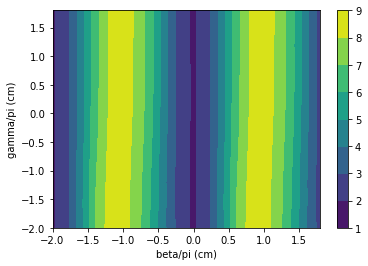

Step 16: Now optimising parameters (Nelder-Mead)...

initial point: pi*[-0.24228169 -1.29229772 -1.62621213 -2.29819593 -1.15222269 -2.28056557

 -2.08448321 -2.22631346 -1.25938277 -2.40644478 -2.4704425  -1.61803253

 -2.2570986  -2.31176678 -2.40463136 -2.         -1.70339875 -2.021852

 -1.84281861 -2.05787643 -1.87774107 -2.11643194 -1.93327249 -2.0703556

 -2.03579582 -2.00075209 -1.99420741 -2.0433482  -1.8827045  -2.12730782

 -1.94417758 -2.        ]

(array([-0.77412577, -3.98124983, -5.23193917, -7.38590341, -3.20446464,

       -7.04601483, -6.25336994, -7.17895266, -4.39765254, -8.33442737,

       -7.17245869, -5.17567546, -7.38864817, -7.42127856, -8.03735327,

       -4.40524818, -5.3363362 , -6.36128234, -5.82409888, -6.43469057,

       -5.88922154, -6.63803678, -6.04620645, -6.5459733 , -6.46254963,

       -6.15943431, -6.34860531, -6.39417285, -5.96467658, -6.65881684,

       -5.99879454, -6.15850799]), 1.813589, 9539)

params/np.pi:  [-0.24641188 -1.26727118 -1.6



min: 1.813589, gamma = -2.0*pi, beta = -2.0*pi

Now drawing plot...


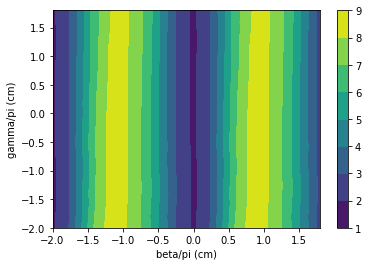

Step 17: Now optimising parameters (Nelder-Mead)...

initial point: pi*[-0.24641188 -1.26727118 -1.66537796 -2.35100608 -1.02001278 -2.24281618

 -1.99050947 -2.28513161 -1.39981628 -2.65293063 -2.28306451 -1.64746867

 -2.35187976 -2.36226633 -2.558369   -1.40223405 -2.         -1.69860857

 -2.02485906 -1.85386825 -2.04822562 -1.87459744 -2.11295273 -1.92456729

 -2.08364801 -2.05709344 -1.96060883 -2.02082384 -2.03532843 -1.89861552

 -2.11956723 -1.90947561 -1.96031398 -2.        ]

(array([-0.77098922, -4.24166105, -4.8853149 , -7.53054383, -2.60248035,

       -7.11932245, -6.64261304, -7.07736806, -4.11788516, -7.51682786,

       -7.08536676, -6.85923713, -7.42651476, -7.27838518, -7.89200004,

       -4.26206178, -7.87317408, -5.35696099, -6.40143765, -5.90163425,

       -6.41758573, -5.88148089, -6.70272097, -6.05108999, -6.55281181,

       -6.58405271, -6.02088164, -6.49619269, -6.34342464, -5.95317913,

       -6.62710257, -5.99513264, -6.09296383, -6.3454364 ]), 1.808125



min: 1.808125, gamma = -2.0*pi, beta = -2.0*pi

Now drawing plot...


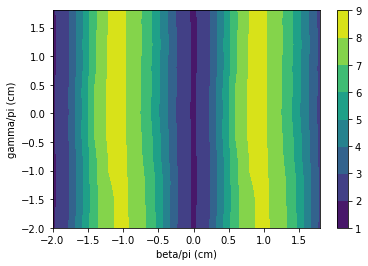

Step 18: Now optimising parameters (Nelder-Mead)...

initial point: pi*[-0.24541349 -1.35016265 -1.55504403 -2.39704655 -0.82839522 -2.26615072

 -2.1144094  -2.25279622 -1.31076356 -2.39268062 -2.25534229 -2.18336299

 -2.36393307 -2.31678196 -2.51210163 -1.3566564  -2.50610914 -2.

 -1.70517364 -2.03764089 -1.87854853 -2.04278098 -1.87213351 -2.13354235

 -1.92612177 -2.08582478 -2.09576907 -1.91650615 -2.06780235 -2.01917477

 -1.89495577 -2.10947227 -1.90830999 -1.93945062 -2.01981514 -2.        ]


KeyboardInterrupt: 

In [287]:
optimal_parameters = continue_find_optimal_params(optimal_parameters, 15, 20, qubo)

In [ ]:
k=17
qaoa_circuit = QAOA(operator = op, p=k, quantum_instance=BasicAer.get_backend('statevector_simulator'))
optimal_circuit = qaoa_circuit.construct_circuit( np.pi*optimal_parameters[0:2*k] )[0]
simulator = Aer.get_backend('statevector_simulator')
result = execute(optimal_circuit, simulator).result()
statevector = Statevector(result.get_statevector())
counts = statevector.sample_counts(shots = 10000)
plot_histogram([counts], figsize = (200,100))

In [ ]:
sort_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
sort_counts